# Deep learning and Machine Learning 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.pyplot as plt

# Modeling and Forecasting
# ==============================================================================
import sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import skforecast
from skforecast.recursive import ForecasterRecursive 
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import TimeSeriesFold, grid_search_forecaster, backtesting_forecaster, random_search_forecaster
from skforecast.preprocessing import RollingFeatures
from skforecast.utils import save_forecaster, load_forecaster
from skforecast.metrics import calculate_coverage
from skforecast.plot import plot_prediction_intervals

c:\Users\andre\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#############################################################################################
# Meta Analysis 

In [2]:
final_meta = pd.read_csv('final_meta.csv')
final_meta.head()

,Date,Open,High,Low,Close,Adj Close,Volume,company,Year,sentiment,knn_mean,knn_imputer,Close_pct_change,sentiment_imputed,sentiment_poly
0,2019-12-31,204.000000,205.559998,203.600006,205.250000,205.250000,8953500,META,2019,NaN,0.258300,0.066540,NaN,0.022067,NaN
1,2020-01-02,206.750000,209.789993,206.270004,209.779999,209.779999,12077100,META,2020,NaN,0.280875,0.227010,0.022067,0.022067,NaN
2,2020-01-03,207.210007,210.399994,206.949997,208.669998,208.669998,11188400,META,2020,NaN,0.280875,0.066540,-0.005291,-0.005291,NaN
3,2020-01-06,206.699997,212.779999,206.520004,212.600006,212.600006,17058900,META,2020,NaN,0.280875,-0.010555,0.018831,0.018831,NaN
4,2020-01-07,212.820007,214.580002,211.750000,213.059998,213.059998,14912400,META,2020,0.2583,0.258300,0.258300,0.002164,0.258300,0.2583


# Recursive multi-step forecasting
- Since the value tn−1 is required to predict tn, and tn−1
 is unknown, a recursive process is applied in which, each new prediction, is based on the previous one. This process is known as recursive forecasting or recursive multi-step forecasting and can be easily generated with the ForecasterRecursive class.


 - When working with time series, it is seldom needed to predict only the next element in the series ( t+1 ). Instead, the most common goal is to
predict a whole future interval (( t+1 ), ..., ( t+n )) or a far point in time ( t+n ). Several strategies allow generating this type of prediction.

Train dates : 0 --- 202  (n=203)
Test dates  : 203 --- 253  (n=51)


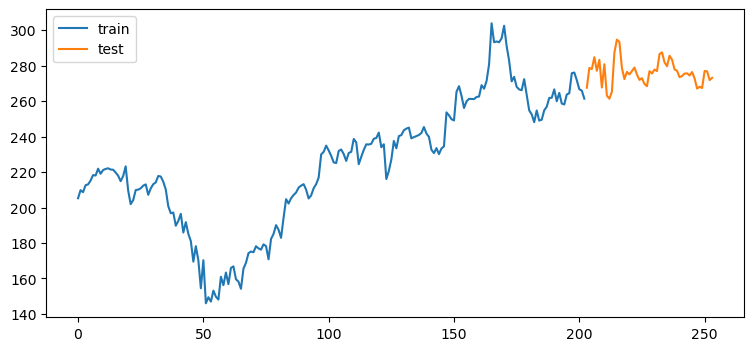

In [3]:
# Split data into train-test
# ==============================================================================
steps = 51
data_train_meta = final_meta[:-steps]
data_test_meta  = final_meta[-steps:]

print(f"Train dates : {data_train_meta.index.min()} --- {data_train_meta.index.max()}  (n={len(data_train_meta)})")
print(f"Test dates  : {data_test_meta.index.min()} --- {data_test_meta.index.max()}  (n={len(data_test_meta)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train_meta['Close'].plot(ax=ax, label='train')
data_test_meta['Close'].plot(ax=ax, label='test')
ax.legend();

In [4]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = DecisionTreeRegressor(random_state=123),
                 lags      = 7,
                 differentiation=1
             )
forecaster.fit(y=data_train_meta['Close'],store_in_sample_residuals=True)
forecaster


=================== 
ForecasterRecursive 
=================== 
Regressor: DecisionTreeRegressor 
Lags: [1 2 3 4 5 6 7] 
Window features: None 
Window size: 8 
Series name: Close 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: 1 
Training range: [0, 202] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: 
    {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None,
    'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf':
    0.0, 'monotonic_cst': None, 'random_state': 123, 'splitter': 'best'} 
fit_kwargs: {} 
Creation date: 2025-05-19 15:10:12 
Last fit date: 2025-05-19 15:10:12 
Skforecast version: 0.16.0 
Python version: 3.11.9 
Forecaster id: None

In [5]:
# Predictions
# ==============================================================================
steps = 51
predictions = forecaster.predict(steps=steps)
results = pd.DataFrame({
    'Actual': data_test_meta['Close'],
    'Predicted': predictions
}, index=data_test_meta.index)

print(results.head(7))

         Actual   Predicted
203  267.559998  268.220001
204  278.730011  262.490005
205  278.119995  263.889999
206  284.790009  269.180008
207  277.109985  269.750015
208  283.290009  273.720016
209  267.670013  274.930023


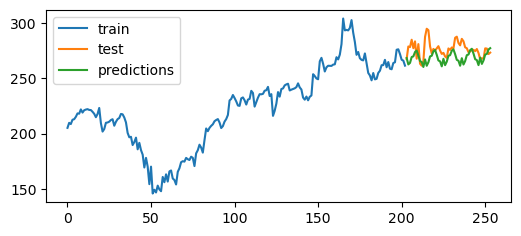

In [6]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train_meta['Close'].plot(ax=ax, label='train')
data_test_meta['Close'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [7]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test_meta['Close'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 131.58535350641858


# Hyperparameter Tuning Grid search


Grid search is a popular hyperparameter tuning technique that evaluate an exaustive list of combinations of hyperparameters and lags to find the optimal configuration for a forecasting model. To perform a grid search with the Skforecast library, two grids are needed: one with different lags (lags_grid) and another with the hyperparameters (param_grid).

The grid search process involves the following steps:

grid_search_forecaster replaces the lags argument with the first option appearing in lags_grid.

The function validates all combinations of hyperparameters presented in param_grid using backtesting.

The function repeats these two steps until it has evaluated all possible combinations of lags and hyperparameters.

If return_best = True, the original forecaster is trained with the best lags and hyperparameters configuration found during the grid search process.

In [8]:
# Hyperparameters: grid search
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = DecisionTreeRegressor(random_state=123),
                 lags      = 7,
                 differentiation=1
             )

# Training and validation folds
cv = TimeSeriesFold(
      steps              = 10,
      initial_train_size = int(len(data_train_meta) * 0.65),
      refit              = False,
      fixed_train_size   = False,
      differentiation=1

    )

# Candidate values for lags

# Lags used as predictors
lags_grid = {
    'lags_1': 3,
    'lags_2': 10,
    'lags_3': [1, 2, 3, 4]}


# Candidate values for regressor's hyperparameters

param_grid = {
    'max_depth': [None, 3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [ 'sqrt', 'log2']
}


results_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = data_train_meta['Close'],
                    cv          = cv,
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    metric      = 'mean_squared_error',  
                    return_best = True,
                    n_jobs      = 'auto',
                    verbose     = False
                )

lags grid: 100%|██████████| 3/3 [00:12<00:00,  4.03s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5}
  Backtesting metric: 160.55753396520484


In [9]:
# Create and train forecaster with the best hyperparameters and lags found
# ==============================================================================
regressor = DecisionTreeRegressor(max_depth = 5,max_features = "log2",min_samples_leaf= 1, random_state=123)
forecaster = ForecasterRecursive(
                 regressor = regressor,
                 lags      = 7,
                 differentiation=1
             )
forecaster.fit(y=data_train_meta['Close'],store_in_sample_residuals=True) 
#forecaster

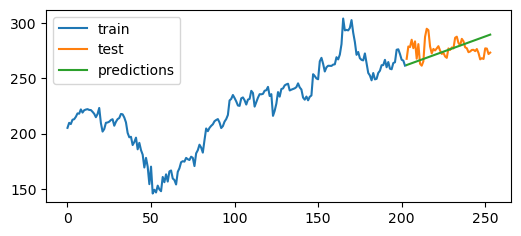

In [10]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)


# # Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train_meta['Close'].plot(ax=ax, label='train')
data_test_meta['Close'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [11]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test_meta['Close'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 126.36936096559889


In [12]:
# Random search hyperparameters and lags
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = DecisionTreeRegressor(random_state=123),
                 lags      = 10  # Placeholder, the value will be overwritten
             )

# Lags used as predictors
lags_grid = [3, 5]

# Regressor hyperparameters
param_distributions = {
    'max_depth': np.arange(start=1, stop=30, step=1, dtype=int),
    'min_samples_leaf': np.arange(start =1 , stop = 5, step = 1, dtype=int)
}

# Folds
cv = TimeSeriesFold(
         steps              = 12,
         initial_train_size =int(len(data_train_meta) * 0.60),
         refit              = False,
     )




results = random_search_forecaster(
              forecaster          = forecaster,
              y                   = data_train_meta['Close'],
              lags_grid           = lags_grid,
              param_distributions = param_distributions,
              cv                  = cv,
              n_iter              = 5,
              metric              = 'mean_squared_error',
              return_best         = True,
              random_state        = 123,
              n_jobs              = 'auto',
              verbose             = False,
              show_progress       = True
          )
results.head(4)

lags grid: 100%|██████████| 2/2 [00:00<00:00,  4.96it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'min_samples_leaf': 1, 'max_depth': 26}
  Backtesting metric: 611.3242618587378


,lags,lags_label,params,mean_squared_error,min_samples_leaf,max_depth
0,"[1, 2, 3]","[1, 2, 3]","{'min_samples_leaf': 1, 'max_depth': 26}",611.324262,1,26
1,"[1, 2, 3]","[1, 2, 3]","{'min_samples_leaf': 1, 'max_depth': 8}",628.822846,1,8
2,"[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'min_samples_leaf': 2, 'max_depth': 23}",629.882080,2,23
3,"[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'min_samples_leaf': 2, 'max_depth': 14}",629.882080,2,14


# Analysis 
For these models, the exogonous variables of tweets sentiment will not be utilised as their correlation with the stock close price was quite low 

## Backtesting with refit and fixed training size

- In this approach, the model is trained using a fixed window of past observations, and the testing is performed on a rolling basis, where the training window is moved forward in time. The size of the training window is kept constant, allowing for the model to be tested on different sections of the data. This technique is particularly useful when there is a limited amount of data available, or when the data is non-stationary, and the model's performance may vary over time. Is also known as time series cross-validation or walk-forward validation.

In [13]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = DecisionTreeRegressor(random_state=123),
                 lags      = 7,
                 differentiation=1
             )
forecaster.fit(y=data_train_meta['Close'],store_in_sample_residuals=True)
forecaster


cv = TimeSeriesFold(
         steps                 = 10,
         initial_train_size    = 150,
         refit                 = True,
         fixed_train_size      = False,
         gap                   = 0,
         allow_incomplete_fold = True,
         differentiation=1
     )

metric, predictions = backtesting_forecaster(
                          forecaster    = forecaster,
                          y             = final_meta['Close'],
                          cv            = cv,
                          metric        = 'mean_squared_error',
                          n_jobs        = 'auto',
                          verbose       = True,
                          show_progress = True
                      )

Information of folds
--------------------
Number of observations used for initial training: 149
    First 1 observation/s in training sets are used for differentiation
Number of observations used for backtesting: 104
    Number of folds: 11
    Number skipped folds: 0 
    Number of steps per fold: 10
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 4 observations.

Fold: 0
    Training:   1 -- 149  (n=149)
    Validation: 150 -- 159  (n=10)
Fold: 1
    Training:   1 -- 159  (n=159)
    Validation: 160 -- 169  (n=10)
Fold: 2
    Training:   1 -- 169  (n=169)
    Validation: 170 -- 179  (n=10)
Fold: 3
    Training:   1 -- 179  (n=179)
    Validation: 180 -- 189  (n=10)
Fold: 4
    Training:   1 -- 189  (n=189)
    Validation: 190 -- 199  (n=10)
Fold: 5
    Training:   1 -- 199  (n=199)
    Validation: 200 -- 209  (n=10)
Fold: 6
    Training:   1 -- 209  (n=209)
    Validation: 210 -- 219  (n=10)
Fold: 7
    Trai

100%|██████████| 11/11 [00:00<00:00, 1737.49it/s]


In [14]:
# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(steps=60, interval=[5, 95], n_boot=100)
predictions.tail(7)

,pred,lower_bound,upper_bound
256,266.960052,266.960052,266.960052
257,262.430054,262.430054,262.430054
258,269.250061,269.250061,269.250061
259,263.520065,263.520065,263.520065
260,266.690063,266.690063,266.690063
261,271.980072,271.980072,271.980072
262,272.550079,272.550079,272.550079


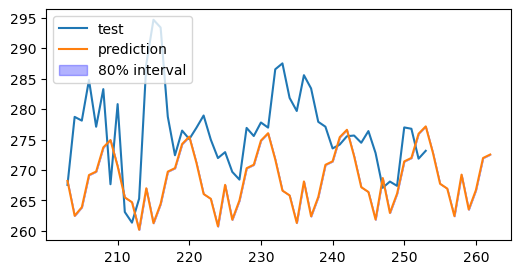

In [15]:
# Plot prediction interval
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data_test_meta['Close'].plot(ax=ax, label="test")
predictions['pred'].plot(ax=ax, label="prediction")
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'blue',
    alpha = 0.3,
    label = '80% interval'
)
ax.legend(loc="upper left");

In [17]:
forecaster.get_feature_importances()


,feature,importance
1,lag_2,0.202015
0,lag_1,0.192904
5,lag_6,0.181714
2,lag_3,0.127574
3,lag_4,0.104516
6,lag_7,0.096966
4,lag_5,0.094311


###################################################################################################################################


# Amazon

In [18]:
final_amzn = pd.read_csv('final_amzn.csv')
final_amzn.head()

,Date,Open,High,Low,Close,Adj Close,Volume,company,Year,sentiment,knn_mean,knn_imputer,Close_pct_change,sentiment_imputed,sentiment_poly
0,2019-12-31,92.099998,92.663002,91.611504,92.391998,92.391998,50130000,AMZN,2019,NaN,0.399433,-0.032413,NaN,0.027144,NaN
1,2020-01-02,93.750000,94.900497,93.207497,94.900497,94.900497,80580000,AMZN,2020,NaN,0.299575,0.329290,0.027144,0.027144,NaN
2,2020-01-03,93.224998,94.309998,93.224998,93.748497,93.748497,75288000,AMZN,2020,0.0000,0.000000,0.000000,-0.012138,0.000000,0.0000
3,2020-01-06,93.000000,95.184502,93.000000,95.143997,95.143997,81236000,AMZN,2020,0.4404,0.440400,0.440400,0.014884,0.440400,0.4404
4,2020-01-07,95.224998,95.694504,94.601997,95.343002,95.343002,80898000,AMZN,2020,0.7579,0.757900,0.757900,0.002092,0.757900,0.7579


Train dates : 0 --- 202  (n=203)
Test dates  : 203 --- 253  (n=51)


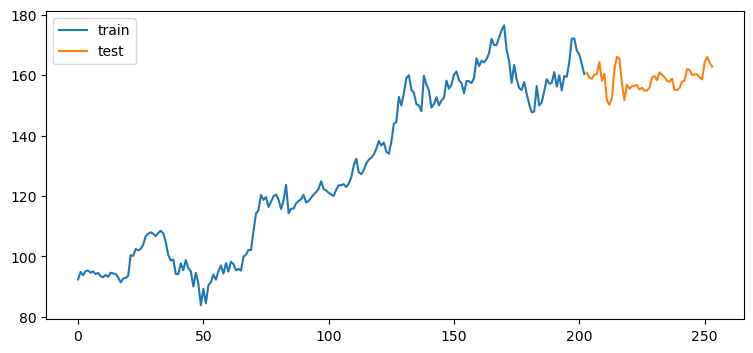

In [19]:
# Split data into train-test
# ==============================================================================
steps = 51
data_train_amzn = final_amzn[:-steps]
data_test_amzn  = final_amzn[-steps:]

print(f"Train dates : {data_train_amzn.index.min()} --- {data_train_amzn.index.max()}  (n={len(data_train_amzn)})")
print(f"Test dates  : {data_test_amzn.index.min()} --- {data_test_amzn.index.max()}  (n={len(data_test_amzn)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train_amzn['Close'].plot(ax=ax, label='train')
data_test_amzn['Close'].plot(ax=ax, label='test')
ax.legend();

In [20]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = DecisionTreeRegressor(random_state=123),
                 lags      = 7,
                 differentiation=1
             )
forecaster.fit(y=data_train_amzn['Close'],store_in_sample_residuals=True)
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: DecisionTreeRegressor 
Lags: [1 2 3 4 5 6 7] 
Window features: None 
Window size: 8 
Series name: Close 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: 1 
Training range: [0, 202] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: 
    {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None,
    'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf':
    0.0, 'monotonic_cst': None, 'random_state': 123, 'splitter': 'best'} 
fit_kwargs: {} 
Creation date: 2025-05-19 15:10:26 
Last fit date: 2025-05-19 15:10:26 
Skforecast version: 0.16.0 
Python version: 3.11.9 
Forecaster id: None

In [21]:
# Predictions
# ==============================================================================
steps = 51
predictions = forecaster.predict(steps=steps)
results = pd.DataFrame({
    'Actual': data_test_amzn['Close'],
    'Predicted': predictions
}, index=data_test_amzn.index)

print(results.head(7))

         Actual   Predicted
203  160.850494  162.129005
204  159.246994  159.385002
205  158.820007  154.620499
206  160.220001  152.792999
207  160.352005  158.432999
208  164.316498  163.497498
209  158.139008  167.443497


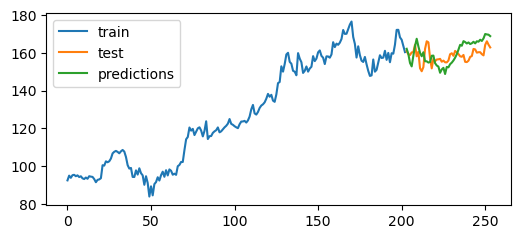

In [22]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train_amzn['Close'].plot(ax=ax, label='train')
data_test_amzn['Close'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [23]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test_amzn['Close'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 35.85052868047535


In [24]:
# Hyperparameters: grid search
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = DecisionTreeRegressor(random_state=123),
                 lags      = 7,
                 differentiation=1
             )

# Training and validation folds
cv = TimeSeriesFold(
      steps              = 10,
      initial_train_size = int(len(data_train_amzn) * 0.65),
      refit              = False,
      fixed_train_size   = False,
      differentiation=1

    )

# Candidate values for lags

# Lags used as predictors
lags_grid = {
    'lags_1': 3,
    'lags_2': 10,
    'lags_3': [1, 2, 3, 4]}


# Candidate values for regressor's hyperparameters

param_grid = {
    'max_depth': [None, 3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [ 'sqrt', 'log2']
}


results_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = data_train_amzn['Close'],
                    cv          = cv,
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    metric      = 'mean_squared_error',  
                    return_best = True,
                    n_jobs      = 'auto',
                    verbose     = False
                )

lags grid: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4] 
  Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}
  Backtesting metric: 57.21772756121901


In [25]:
# Create and train forecaster with the best hyperparameters and lags found
# ==============================================================================
regressor = DecisionTreeRegressor(max_depth = None,max_features = 'sqrt' ,min_samples_leaf= 1, random_state=123)
forecaster = ForecasterRecursive(
                 regressor = regressor,
                 lags      =4,
                 differentiation=1
             )
forecaster.fit(y=data_train_amzn['Close'],store_in_sample_residuals=True) 
#forecaster

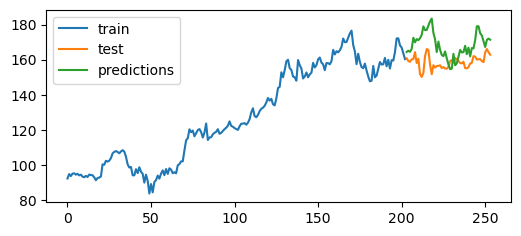

In [26]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)


# # Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train_amzn['Close'].plot(ax=ax, label='train')
data_test_amzn['Close'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [27]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test_amzn['Close'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 153.08827779265394


In [28]:
# Random search hyperparameters and lags
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = DecisionTreeRegressor(random_state=123),
                 lags      = 10  # Placeholder, the value will be overwritten
             )

# Lags used as predictors
lags_grid = [3, 5]

# Regressor hyperparameters
param_distributions = {
    'max_depth': np.arange(start=1, stop=30, step=1, dtype=int),
    'min_samples_leaf': np.arange(start =1 , stop = 5, step = 1, dtype=int)
}

# Folds
cv = TimeSeriesFold(
         steps              = 12,
         initial_train_size =int(len(data_train_amzn) * 0.60),
         refit              = False,
     )




results = random_search_forecaster(
              forecaster          = forecaster,
              y                   = data_train_amzn['Close'],
              lags_grid           = lags_grid,
              param_distributions = param_distributions,
              cv                  = cv,
              n_iter              = 5,
              metric              = 'mean_squared_error',
              return_best         = True,
              random_state        = 123,
              n_jobs              = 'auto',
              verbose             = False,
              show_progress       = True
          )
results.head(4)

lags grid: 100%|██████████| 2/2 [00:00<00:00,  5.26it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'min_samples_leaf': 1, 'max_depth': 26}
  Backtesting metric: 437.57671601104084


,lags,lags_label,params,mean_squared_error,min_samples_leaf,max_depth
0,"[1, 2, 3]","[1, 2, 3]","{'min_samples_leaf': 1, 'max_depth': 26}",437.576716,1,26
1,"[1, 2, 3]","[1, 2, 3]","{'min_samples_leaf': 1, 'max_depth': 8}",437.576716,1,8
2,"[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'min_samples_leaf': 1, 'max_depth': 26}",437.576716,1,26
3,"[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'min_samples_leaf': 1, 'max_depth': 8}",437.576716,1,8


# Analysis 
For these models, the exogonous variables of tweets sentiment will not be utilised as their correlation with the stock close price was quite low 

## Backtesting with refit and fixed training size

- In this approach, the model is trained using a fixed window of past observations, and the testing is performed on a rolling basis, where the training window is moved forward in time. The size of the training window is kept constant, allowing for the model to be tested on different sections of the data. This technique is particularly useful when there is a limited amount of data available, or when the data is non-stationary, and the model's performance may vary over time. Is also known as time series cross-validation or walk-forward validation.

In [29]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = DecisionTreeRegressor(random_state=123),
                 lags      = 7,
                 differentiation=1
             )
forecaster.fit(y=data_train_amzn['Close'],store_in_sample_residuals=True)
forecaster


cv = TimeSeriesFold(
         steps                 = 10,
         initial_train_size    = 150,
         refit                 = True,
         fixed_train_size      = False,
         gap                   = 0,
         allow_incomplete_fold = True,
         differentiation=1
     )

metric, predictions = backtesting_forecaster(
                          forecaster    = forecaster,
                          y             = final_amzn['Close'],
                          cv            = cv,
                          metric        = 'mean_squared_error',
                          n_jobs        = 'auto',
                          verbose       = True,
                          show_progress = True
                      )

Information of folds
--------------------
Number of observations used for initial training: 149
    First 1 observation/s in training sets are used for differentiation
Number of observations used for backtesting: 104
    Number of folds: 11
    Number skipped folds: 0 
    Number of steps per fold: 10
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 4 observations.

Fold: 0
    Training:   1 -- 149  (n=149)
    Validation: 150 -- 159  (n=10)
Fold: 1
    Training:   1 -- 159  (n=159)
    Validation: 160 -- 169  (n=10)
Fold: 2
    Training:   1 -- 169  (n=169)
    Validation: 170 -- 179  (n=10)
Fold: 3
    Training:   1 -- 179  (n=179)
    Validation: 180 -- 189  (n=10)
Fold: 4
    Training:   1 -- 189  (n=189)
    Validation: 190 -- 199  (n=10)
Fold: 5
    Training:   1 -- 199  (n=199)
    Validation: 200 -- 209  (n=10)
Fold: 6
    Training:   1 -- 209  (n=209)
    Validation: 210 -- 219  (n=10)
Fold: 7
    Trai

100%|██████████| 11/11 [00:00<?, ?it/s]


In [30]:
# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(steps=60, interval=[5, 95], n_boot=100)
predictions.tail(7)

,pred,lower_bound,upper_bound
256,170.279495,170.279495,170.279495
257,169.423492,169.423492,169.423492
258,165.089493,165.089493,165.089493
259,164.442490,164.442490,164.442490
260,161.882484,161.882484,161.882484
261,158.607491,158.607491,158.607491
262,156.942490,156.942490,156.942490


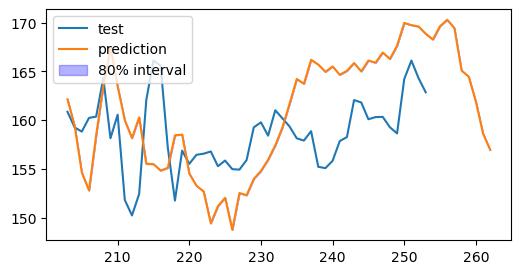

In [31]:
# Plot prediction interval
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data_test_amzn['Close'].plot(ax=ax, label="test")
predictions['pred'].plot(ax=ax, label="prediction")
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'blue',
    alpha = 0.3,
    label = '80% interval'
)
ax.legend(loc="upper left");

In [33]:
forecaster.get_feature_importances()


,feature,importance
2,lag_3,0.199286
0,lag_1,0.173398
1,lag_2,0.170289
4,lag_5,0.157500
6,lag_7,0.146369
3,lag_4,0.107944
5,lag_6,0.045214


#################################################################################################################
#################################################################################################################

# Apple 

In [34]:
final_aapl = pd.read_csv('final_aapl.csv')
final_aapl.head()

,Date,Open,High,Low,Close,Adj Close,Volume,company,Year,sentiment,knn_mean,knn_imputer,Close_pct_change,sentiment_imputed,sentiment_poly
0,2019-12-31,72.482498,73.419998,72.379997,73.412498,71.520821,100805600,AAPL,2019,NaN,0.253212,0.095975,NaN,0.376125,NaN
1,2020-01-02,74.059998,75.150002,73.797501,75.087502,73.152649,135480400,AAPL,2020,0.376125,0.376125,0.376125,0.022812,0.376125,0.376125
2,2020-01-03,74.287498,75.144997,74.125000,74.357498,72.441460,146322800,AAPL,2020,0.103833,0.103833,0.103833,-0.009722,0.103833,0.103833
3,2020-01-06,73.447502,74.989998,73.187500,74.949997,73.018677,118387200,AAPL,2020,0.779300,0.779300,0.779300,0.007968,0.779300,0.779300
4,2020-01-07,74.959999,75.224998,74.370003,74.597504,72.675278,108872000,AAPL,2020,0.069367,0.069367,0.069367,-0.004703,0.069367,0.069367


Train dates : 0 --- 202  (n=203)
Test dates  : 203 --- 253  (n=51)


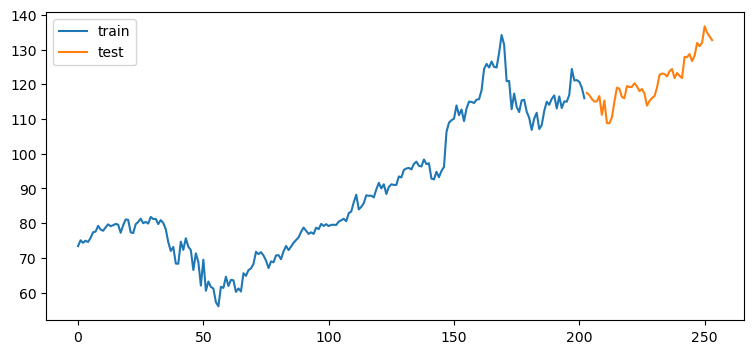

In [35]:
# Split data into train-test
# ==============================================================================
steps = 51
data_train_aapl = final_aapl[:-steps]
data_test_aapl  = final_aapl[-steps:]

print(f"Train dates : {data_train_aapl.index.min()} --- {data_train_aapl.index.max()}  (n={len(data_train_aapl)})")
print(f"Test dates  : {data_test_aapl.index.min()} --- {data_test_aapl.index.max()}  (n={len(data_test_aapl)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train_aapl['Close'].plot(ax=ax, label='train')
data_test_aapl['Close'].plot(ax=ax, label='test')
ax.legend();

In [36]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = DecisionTreeRegressor(random_state=123),
                 lags      = 7,
                 differentiation=1
             )
forecaster.fit(y=data_train_aapl['Close'],store_in_sample_residuals=True)
forecaster


=================== 
ForecasterRecursive 
=================== 
Regressor: DecisionTreeRegressor 
Lags: [1 2 3 4 5 6 7] 
Window features: None 
Window size: 8 
Series name: Close 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: 1 
Training range: [0, 202] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: 
    {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None,
    'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf':
    0.0, 'monotonic_cst': None, 'random_state': 123, 'splitter': 'best'} 
fit_kwargs: {} 
Creation date: 2025-05-19 15:10:33 
Last fit date: 2025-05-19 15:10:33 
Skforecast version: 0.16.0 
Python version: 3.11.9 
Forecaster id: None

In [37]:
# Predictions
# ==============================================================================
steps = 51
predictions = forecaster.predict(steps=steps)
results = pd.DataFrame({
    'Actual': data_test_aapl['Close'],
    'Predicted': predictions
}, index=data_test_aapl.index)

print(results.head(7))

         Actual   Predicted
203  117.510002  115.100006
204  116.870003  111.600006
205  115.750000  111.145012
206  115.040001  108.620010
207  115.050003  110.907516
208  116.599998  113.570015
209  111.199997  115.555016


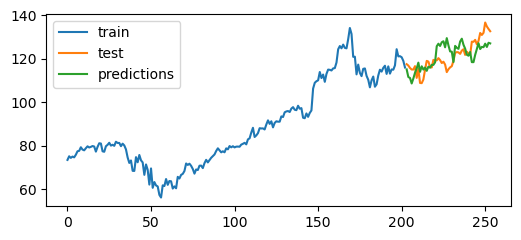

In [38]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train_aapl['Close'].plot(ax=ax, label='train')
data_test_aapl['Close'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [39]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test_aapl['Close'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 36.09598417781737


# Hyperparameter Tuning Grid search


Grid search is a popular hyperparameter tuning technique that evaluate an exaustive list of combinations of hyperparameters and lags to find the optimal configuration for a forecasting model. To perform a grid search with the Skforecast library, two grids are needed: one with different lags (lags_grid) and another with the hyperparameters (param_grid).

The grid search process involves the following steps:

grid_search_forecaster replaces the lags argument with the first option appearing in lags_grid.

The function validates all combinations of hyperparameters presented in param_grid using backtesting.

The function repeats these two steps until it has evaluated all possible combinations of lags and hyperparameters.

If return_best = True, the original forecaster is trained with the best lags and hyperparameters configuration found during the grid search process.

In [40]:
# Hyperparameters: grid search
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = DecisionTreeRegressor(random_state=123),
                 lags      = 7,
                 differentiation=1
             )

# Training and validation folds
cv = TimeSeriesFold(
      steps              = 10,
      initial_train_size = int(len(data_train_aapl) * 0.65),
      refit              = False,
      fixed_train_size   = False,
      differentiation=1

    )

# Candidate values for lags

# Lags used as predictors
lags_grid = {
    'lags_1': 3,
    'lags_2': 10,
    'lags_3': [1, 2, 3, 4]}


# Candidate values for regressor's hyperparameters

param_grid = {
    'max_depth': [None, 3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [ 'sqrt', 'log2']
}


results_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = data_train_aapl['Close'],
                    cv          = cv,
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    metric      = 'mean_squared_error',  
                    return_best = True,
                    n_jobs      = 'auto',
                    verbose     = False
                )

lags grid: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
  Backtesting metric: 37.856673660043604


In [41]:
# Create and train forecaster with the best hyperparameters and lags found
# ==============================================================================
regressor = DecisionTreeRegressor(max_depth = 5,max_features = "log2",min_samples_leaf= 1, random_state=123)
forecaster = ForecasterRecursive(
                 regressor = regressor,
                 lags      = 7,
                 differentiation=1
             )
forecaster.fit(y=data_train_aapl['Close'],store_in_sample_residuals=True) 
#forecaster

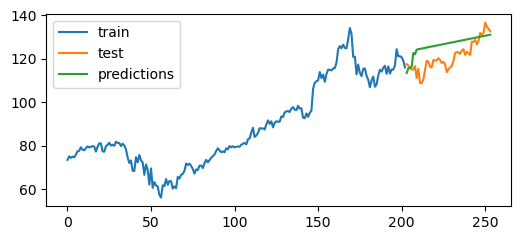

In [42]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)


# # Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train_aapl['Close'].plot(ax=ax, label='train')
data_test_aapl['Close'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [43]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test_aapl['Close'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 57.604331320374


In [44]:
# Random search hyperparameters and lags
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = DecisionTreeRegressor(random_state=123),
                 lags      = 10  # Placeholder, the value will be overwritten
             )

# Lags used as predictors
lags_grid = [3, 5]

# Regressor hyperparameters
param_distributions = {
    'max_depth': np.arange(start=1, stop=30, step=1, dtype=int),
    'min_samples_leaf': np.arange(start =1 , stop = 5, step = 1, dtype=int)
}

# Folds
cv = TimeSeriesFold(
         steps              = 12,
         initial_train_size =int(len(data_train_aapl) * 0.60),
         refit              = False,
     )




results = random_search_forecaster(
              forecaster          = forecaster,
              y                   = data_train_aapl['Close'],
              lags_grid           = lags_grid,
              param_distributions = param_distributions,
              cv                  = cv,
              n_iter              = 5,
              metric              = 'mean_squared_error',
              return_best         = True,
              random_state        = 123,
              n_jobs              = 'auto',
              verbose             = False,
              show_progress       = True
          )
results.head(4)

lags grid: 100%|██████████| 2/2 [00:00<00:00,  5.03it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'min_samples_leaf': 1, 'max_depth': 26}
  Backtesting metric: 448.2292261985649


,lags,lags_label,params,mean_squared_error,min_samples_leaf,max_depth
0,"[1, 2, 3]","[1, 2, 3]","{'min_samples_leaf': 1, 'max_depth': 26}",448.229226,1,26
1,"[1, 2, 3]","[1, 2, 3]","{'min_samples_leaf': 1, 'max_depth': 8}",448.229226,1,8
2,"[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'min_samples_leaf': 1, 'max_depth': 26}",448.229226,1,26
3,"[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'min_samples_leaf': 1, 'max_depth': 8}",448.229226,1,8


# Analysis 
For these models, the exogonous variables of tweets sentiment will not be utilised as their correlation with the stock close price was quite low 

## Backtesting with refit and fixed training size

- In this approach, the model is trained using a fixed window of past observations, and the testing is performed on a rolling basis, where the training window is moved forward in time. The size of the training window is kept constant, allowing for the model to be tested on different sections of the data. This technique is particularly useful when there is a limited amount of data available, or when the data is non-stationary, and the model's performance may vary over time. Is also known as time series cross-validation or walk-forward validation.

In [45]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = DecisionTreeRegressor(random_state=123),
                 lags      = 7,
                 differentiation=1
             )
forecaster.fit(y=data_train_aapl['Close'],store_in_sample_residuals=True)
forecaster


cv = TimeSeriesFold(
         steps                 = 10,
         initial_train_size    = 150,
         refit                 = True,
         fixed_train_size      = False,
         gap                   = 0,
         allow_incomplete_fold = True,
         differentiation=1
     )

metric, predictions = backtesting_forecaster(
                          forecaster    = forecaster,
                          y             = final_aapl['Close'],
                          cv            = cv,
                          metric        = 'mean_squared_error',
                          n_jobs        = 'auto',
                          verbose       = True,
                          show_progress = True
                      )

Information of folds
--------------------
Number of observations used for initial training: 149
    First 1 observation/s in training sets are used for differentiation
Number of observations used for backtesting: 104
    Number of folds: 11
    Number skipped folds: 0 
    Number of steps per fold: 10
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 4 observations.

Fold: 0
    Training:   1 -- 149  (n=149)
    Validation: 150 -- 159  (n=10)
Fold: 1
    Training:   1 -- 159  (n=159)
    Validation: 160 -- 169  (n=10)
Fold: 2
    Training:   1 -- 169  (n=169)
    Validation: 170 -- 179  (n=10)
Fold: 3
    Training:   1 -- 179  (n=179)
    Validation: 180 -- 189  (n=10)
Fold: 4
    Training:   1 -- 189  (n=189)
    Validation: 190 -- 199  (n=10)
Fold: 5
    Training:   1 -- 199  (n=199)
    Validation: 200 -- 209  (n=10)
Fold: 6
    Training:   1 -- 209  (n=209)
    Validation: 210 -- 219  (n=10)
Fold: 7
    Trai

100%|██████████| 11/11 [00:00<00:00, 17966.26it/s]


In [46]:
# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(steps=60, interval=[5, 95], n_boot=100)
predictions.tail(7)

,pred,lower_bound,upper_bound
256,127.725033,127.725033,127.725033
257,127.725033,127.725033,127.725033
258,128.880032,128.880032,128.880032
259,128.050030,128.050030,128.050030
260,126.237530,126.237530,126.237530
261,124.750027,124.750027,124.750027
262,124.482525,124.482525,124.482525


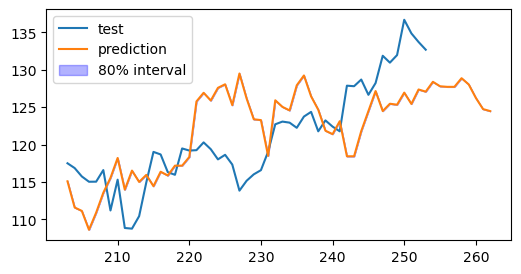

In [47]:
# Plot prediction interval
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data_test_aapl['Close'].plot(ax=ax, label="test")
predictions['pred'].plot(ax=ax, label="prediction")
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'blue',
    alpha = 0.3,
    label = '80% interval'
)
ax.legend(loc="upper left");

In [49]:
forecaster.get_feature_importances()


,feature,importance
6,lag_7,0.274600
1,lag_2,0.252930
5,lag_6,0.173923
4,lag_5,0.098899
2,lag_3,0.079981
0,lag_1,0.064046
3,lag_4,0.055623


###################################################################################################################################


# Netflix


In [50]:
final_nflx = pd.read_csv('final_nflx.csv')
final_nflx.head()

,Date,Open,High,Low,Close,Adj Close,Volume,company,Year,date,sentiment,knn_mean,knn_imputer,Close_pct_change,sentiment_imputed,sentiment_poly
0,2019-12-31,322.000000,324.920013,321.089996,323.570007,323.570007,3713300,NFLX,2019,NaN,NaN,0.00000,0.095975,NaN,0.019282,NaN
1,2020-01-02,326.100006,329.980011,324.779999,329.809998,329.809998,4485800,NFLX,2020,NaN,NaN,0.00000,0.376125,0.019282,0.019282,NaN
2,2020-01-03,326.779999,329.859985,325.529999,325.899994,325.899994,3806900,NFLX,2020,NaN,NaN,0.28595,0.103833,-0.011855,-0.011855,NaN
3,2020-01-06,323.119995,336.359985,321.200012,335.829987,335.829987,5663100,NFLX,2020,2020-01-06,0.0,0.00000,0.779300,0.030460,0.000000,0.000000
4,2020-01-07,336.470001,336.700012,330.299988,330.750000,330.750000,4703200,NFLX,2020,NaN,NaN,0.28595,0.069367,-0.015126,-0.015126,0.142975


Train dates : 0 --- 202  (n=203)
Test dates  : 203 --- 253  (n=51)


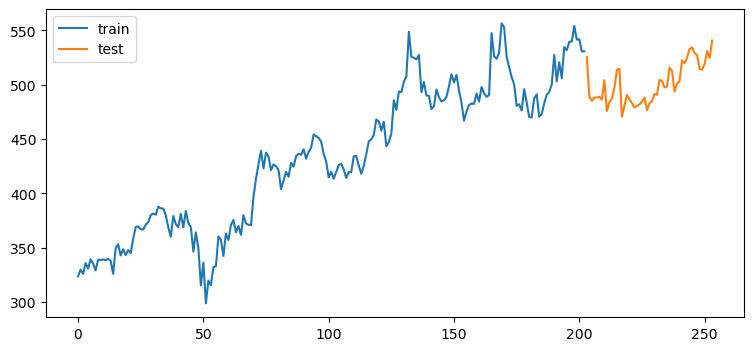

In [51]:
# Split data into train-test
# ==============================================================================
steps = 51
data_train_nflx = final_nflx[:-steps]
data_test_nflx  = final_nflx[-steps:]

print(f"Train dates : {data_train_nflx.index.min()} --- {data_train_nflx.index.max()}  (n={len(data_train_nflx)})")
print(f"Test dates  : {data_test_nflx.index.min()} --- {data_test_nflx.index.max()}  (n={len(data_test_nflx)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train_nflx['Close'].plot(ax=ax, label='train')
data_test_nflx['Close'].plot(ax=ax, label='test')
ax.legend();

In [52]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = DecisionTreeRegressor(random_state=123),
                 lags      = 7,
                 differentiation=1
             )
forecaster.fit(y=data_train_nflx['Close'],store_in_sample_residuals=True)
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: DecisionTreeRegressor 
Lags: [1 2 3 4 5 6 7] 
Window features: None 
Window size: 8 
Series name: Close 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: 1 
Training range: [0, 202] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: 
    {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None,
    'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf':
    0.0, 'monotonic_cst': None, 'random_state': 123, 'splitter': 'best'} 
fit_kwargs: {} 
Creation date: 2025-05-19 15:10:39 
Last fit date: 2025-05-19 15:10:39 
Skforecast version: 0.16.0 
Python version: 3.11.9 
Forecaster id: None

In [53]:
# Predictions
# ==============================================================================
steps = 51
predictions = forecaster.predict(steps=steps)
results = pd.DataFrame({
    'Actual': data_test_nflx['Close'],
    'Predicted': predictions
}, index=data_test_nflx.index)

print(results.head(7))

         Actual   Predicted
203  525.419983  508.239960
204  489.049988  505.859955
205  485.230011  505.619934
206  488.279999  525.349915
207  488.239990  513.219910
208  488.929993  502.939911
209  486.239990  502.699890


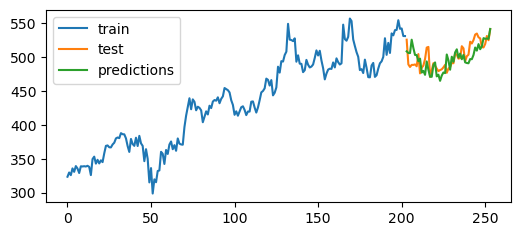

In [54]:
# Predictions
# ==============================================================================
steps = 51
predictions = forecaster.predict(steps=steps)
results = pd.DataFrame({
    'Actual': data_test_nflx['Close'],
    'Predicted': predictions
}, index=data_test_nflx.index)

print(results.head(7))

In [55]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test_nflx['Close'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 238.33074072401615


# Hyperparameter Tuning Grid search


Grid search is a popular hyperparameter tuning technique that evaluate an exaustive list of combinations of hyperparameters and lags to find the optimal configuration for a forecasting model. To perform a grid search with the Skforecast library, two grids are needed: one with different lags (lags_grid) and another with the hyperparameters (param_grid).

The grid search process involves the following steps:

grid_search_forecaster replaces the lags argument with the first option appearing in lags_grid.

The function validates all combinations of hyperparameters presented in param_grid using backtesting.

The function repeats these two steps until it has evaluated all possible combinations of lags and hyperparameters.

If return_best = True, the original forecaster is trained with the best lags and hyperparameters configuration found during the grid search process.

In [56]:
# Hyperparameters: grid search
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = DecisionTreeRegressor(random_state=123),
                 lags      = 7,
                 differentiation=1
             )

# Training and validation folds
cv = TimeSeriesFold(
      steps              = 10,
      initial_train_size = int(len(data_train_nflx) * 0.65),
      refit              = False,
      fixed_train_size   = False,
      differentiation=1

    )

# Candidate values for lags

# Lags used as predictors
lags_grid = {
    'lags_1': 3,
    'lags_2': 10,
    'lags_3': [1, 2, 3, 4]}


# Candidate values for regressor's hyperparameters

param_grid = {
    'max_depth': [None, 3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [ 'sqrt', 'log2']
}


results_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = data_train_nflx['Close'],
                    cv          = cv,
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    metric      = 'mean_squared_error',  
                    return_best = True,
                    n_jobs      = 'auto',
                    verbose     = False
                )

lags grid: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5}
  Backtesting metric: 876.434160944806


In [57]:
# Create and train forecaster with the best hyperparameters and lags found
# ==============================================================================
regressor = DecisionTreeRegressor( random_state=123)
forecaster = ForecasterRecursive(
                 regressor = regressor,
                 lags      = 7 ,
                 differentiation=1
             )
forecaster.fit(y=data_train_nflx['Close'],store_in_sample_residuals=True) 
#forecaster

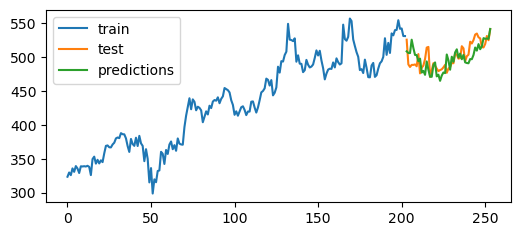

In [58]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)


# # Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train_nflx['Close'].plot(ax=ax, label='train')
data_test_nflx['Close'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [59]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test_nflx['Close'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 238.33074072401615


In [60]:
# Random search hyperparameters and lags
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = DecisionTreeRegressor(random_state=123),
                 lags      = 10  # Placeholder, the value will be overwritten
             )

# Lags used as predictors
lags_grid = [3, 5]

# Regressor hyperparameters
param_distributions = {
    'max_depth': np.arange(start=1, stop=30, step=1, dtype=int),
    'min_samples_leaf': np.arange(start =1 , stop = 5, step = 1, dtype=int)
}

# Folds
cv = TimeSeriesFold(
         steps              = 12,
         initial_train_size =int(len(data_train_nflx) * 0.60),
         refit              = False,
     )




results = random_search_forecaster(
              forecaster          = forecaster,
              y                   = data_train_nflx['Close'],
              lags_grid           = lags_grid,
              param_distributions = param_distributions,
              cv                  = cv,
              n_iter              = 5,
              metric              = 'mean_squared_error',
              return_best         = True,
              random_state        = 123,
              n_jobs              = 'auto',
              verbose             = False,
              show_progress       = True
          )
results.head(4)

lags grid: 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'min_samples_leaf': 1, 'max_depth': 26}
  Backtesting metric: 1818.5579518565976


,lags,lags_label,params,mean_squared_error,min_samples_leaf,max_depth
0,"[1, 2, 3]","[1, 2, 3]","{'min_samples_leaf': 1, 'max_depth': 26}",1818.557952,1,26
1,"[1, 2, 3]","[1, 2, 3]","{'min_samples_leaf': 1, 'max_depth': 8}",1818.557952,1,8
2,"[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'min_samples_leaf': 1, 'max_depth': 26}",1818.557952,1,26
3,"[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'min_samples_leaf': 1, 'max_depth': 8}",1818.557952,1,8


# Analysis 
For these models, the exogonous variables of tweets sentiment will not be utilised as their correlation with the stock close price was quite low 

## Backtesting with refit and fixed training size

- In this approach, the model is trained using a fixed window of past observations, and the testing is performed on a rolling basis, where the training window is moved forward in time. The size of the training window is kept constant, allowing for the model to be tested on different sections of the data. This technique is particularly useful when there is a limited amount of data available, or when the data is non-stationary, and the model's performance may vary over time. Is also known as time series cross-validation or walk-forward validation.

In [61]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = DecisionTreeRegressor(random_state=123),
                 lags      = 7,
                 differentiation=1
             )
forecaster.fit(y=data_train_nflx['Close'],store_in_sample_residuals=True)
forecaster


cv = TimeSeriesFold(
         steps                 = 10,
         initial_train_size    = 150,
         refit                 = True,
         fixed_train_size      = False,
         gap                   = 0,
         allow_incomplete_fold = True,
         differentiation=1
     )

metric, predictions = backtesting_forecaster(
                          forecaster    = forecaster,
                          y             = final_nflx['Close'],
                          cv            = cv,
                          metric        = 'mean_squared_error',
                          n_jobs        = 'auto',
                          verbose       = True,
                          show_progress = True
                      )

Information of folds
--------------------
Number of observations used for initial training: 149
    First 1 observation/s in training sets are used for differentiation
Number of observations used for backtesting: 104
    Number of folds: 11
    Number skipped folds: 0 
    Number of steps per fold: 10
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 4 observations.

Fold: 0
    Training:   1 -- 149  (n=149)
    Validation: 150 -- 159  (n=10)
Fold: 1
    Training:   1 -- 159  (n=159)
    Validation: 160 -- 169  (n=10)
Fold: 2
    Training:   1 -- 169  (n=169)
    Validation: 170 -- 179  (n=10)
Fold: 3
    Training:   1 -- 179  (n=179)
    Validation: 180 -- 189  (n=10)
Fold: 4
    Training:   1 -- 189  (n=189)
    Validation: 190 -- 199  (n=10)
Fold: 5
    Training:   1 -- 199  (n=199)
    Validation: 200 -- 209  (n=10)
Fold: 6
    Training:   1 -- 209  (n=209)
    Validation: 210 -- 219  (n=10)
Fold: 7
    Trai

100%|██████████| 11/11 [00:00<?, ?it/s]


In [62]:
# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(steps=60, interval=[5, 95], n_boot=100)
predictions.tail(7)

,pred,lower_bound,upper_bound
256,525.639832,525.639832,525.639832
257,533.069824,533.069824,533.069824
258,543.699829,543.699829,543.699829
259,555.339813,555.339813,555.339813
260,557.439819,557.439819,557.439819
261,561.289825,561.289825,561.289825
262,575.609833,575.609833,575.609833


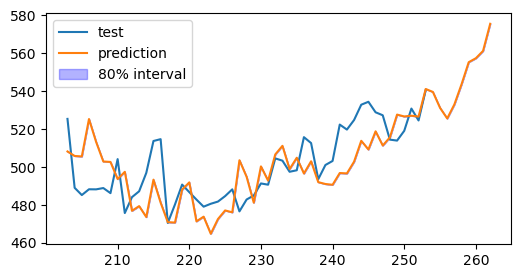

In [63]:
# Plot prediction interval
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data_test_nflx['Close'].plot(ax=ax, label="test")
predictions['pred'].plot(ax=ax, label="prediction")
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'blue',
    alpha = 0.3,
    label = '80% interval'
)
ax.legend(loc="upper left");

In [65]:
forecaster.get_feature_importances()


,feature,importance
0,lag_1,0.225074
4,lag_5,0.206833
5,lag_6,0.188814
2,lag_3,0.106755
3,lag_4,0.103435
6,lag_7,0.090986
1,lag_2,0.078103


#############################################################################################
# Google Analysis 

In [66]:
final_goog = pd.read_csv('final_goog.csv')
final_goog.head()

,Date,Open,High,Low,Close,Adj Close,Volume,company,Year,sentiment,knn_mean,knn_imputer,Close_pct_change,sentiment_imputed,sentiment_poly
0,2019-12-31,66.505501,66.900002,66.454247,66.850998,66.850998,19236000,GOOG,2019,NaN,0.4404,0.13354,NaN,0.022696,NaN
1,2020-01-02,67.077499,68.406998,67.077499,68.368500,68.368500,28132000,GOOG,2020,NaN,0.4404,0.22530,0.022696,0.022696,NaN
2,2020-01-03,67.392998,68.625000,67.277199,68.032997,68.032997,23728000,GOOG,2020,0.4404,0.4404,0.44040,-0.004907,0.440400,0.44040
3,2020-01-06,67.500000,69.824997,67.500000,69.710503,69.710503,34646000,GOOG,2020,NaN,0.4404,0.14502,0.024652,0.024652,0.42818
4,2020-01-07,69.897003,70.149498,69.518997,69.667000,69.667000,30054000,GOOG,2020,NaN,0.4404,0.25328,-0.000624,-0.000624,0.41596


# Recursive multi-step forecasting
- Since the value tn−1 is required to predict tn, and tn−1
 is unknown, a recursive process is applied in which, each new prediction, is based on the previous one. This process is known as recursive forecasting or recursive multi-step forecasting and can be easily generated with the ForecasterRecursive class.


 - When working with time series, it is seldom needed to predict only the next element in the series ( t+1 ). Instead, the most common goal is to
predict a whole future interval (( t+1 ), ..., ( t+n )) or a far point in time ( t+n ). Several strategies allow generating this type of prediction.

Train dates : 0 --- 202  (n=203)
Test dates  : 203 --- 253  (n=51)


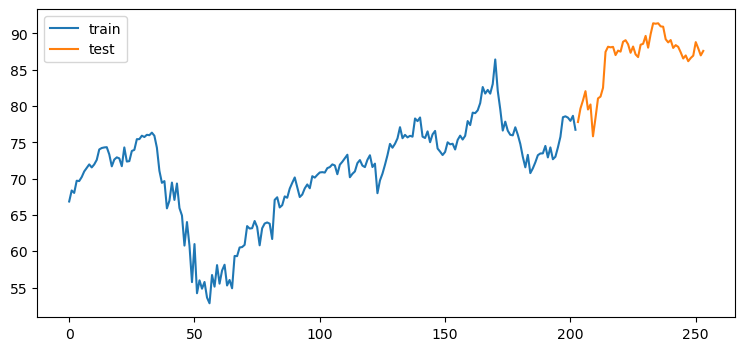

In [67]:
# Split data into train-test
# ==============================================================================
steps = 51
data_train_goog = final_goog[:-steps]
data_test_goog  = final_goog[-steps:]

print(f"Train dates : {data_train_goog.index.min()} --- {data_train_goog.index.max()}  (n={len(data_train_goog)})")
print(f"Test dates  : {data_test_goog.index.min()} --- {data_test_goog.index.max()}  (n={len(data_test_goog)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train_goog['Close'].plot(ax=ax, label='train')
data_test_goog['Close'].plot(ax=ax, label='test')
ax.legend();

In [68]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = DecisionTreeRegressor(random_state=123),
                 lags      = 7,
                 differentiation=1
             )
forecaster.fit(y=data_train_goog['Close'],store_in_sample_residuals=True)
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: DecisionTreeRegressor 
Lags: [1 2 3 4 5 6 7] 
Window features: None 
Window size: 8 
Series name: Close 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: 1 
Training range: [0, 202] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: 
    {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None,
    'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf':
    0.0, 'monotonic_cst': None, 'random_state': 123, 'splitter': 'best'} 
fit_kwargs: {} 
Creation date: 2025-05-19 15:10:46 
Last fit date: 2025-05-19 15:10:46 
Skforecast version: 0.16.0 
Python version: 3.11.9 
Forecaster id: None

In [69]:
# Predictions
# ==============================================================================
steps = 51
predictions = forecaster.predict(steps=steps)
results = pd.DataFrame({
    'Actual': data_test_goog['Close'],
    'Predicted': predictions
}, index=data_test_goog.index)

print(results.head(7))

        Actual  Predicted
203  77.796501  77.192497
204  79.665497  75.563492
205  80.766502  76.784996
206  82.050003  77.785995
207  79.522499  78.974495
208  80.212997  80.307495
209  75.831001  80.778999


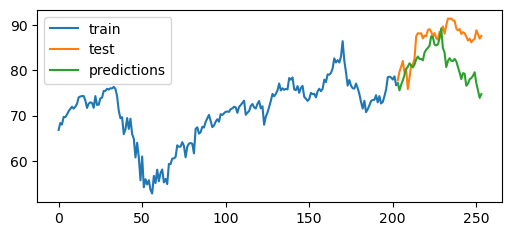

In [70]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train_goog['Close'].plot(ax=ax, label='train')
data_test_goog['Close'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [71]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test_goog['Close'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 46.62246784104683


# Hyperparameter Tuning Grid search


Grid search is a popular hyperparameter tuning technique that evaluate an exaustive list of combinations of hyperparameters and lags to find the optimal configuration for a forecasting model. To perform a grid search with the Skforecast library, two grids are needed: one with different lags (lags_grid) and another with the hyperparameters (param_grid).

The grid search process involves the following steps:

grid_search_forecaster replaces the lags argument with the first option appearing in lags_grid.

The function validates all combinations of hyperparameters presented in param_grid using backtesting.

The function repeats these two steps until it has evaluated all possible combinations of lags and hyperparameters.

If return_best = True, the original forecaster is trained with the best lags and hyperparameters configuration found during the grid search process.

In [72]:
# Hyperparameters: grid search
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = DecisionTreeRegressor(random_state=123),
                 lags      = 7,
                 differentiation=1
             )

# Training and validation folds
cv = TimeSeriesFold(
      steps              = 10,
      initial_train_size = int(len(data_train_goog) * 0.65),
      refit              = False,
      fixed_train_size   = False,
      differentiation=1

    )

# Candidate values for lags

# Lags used as predictors
lags_grid = {
    'lags_1': 3,
    'lags_2': 10,
    'lags_3': [1, 2, 3, 4]}


# Candidate values for regressor's hyperparameters

param_grid = {
    'max_depth': [None, 3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [ 'sqrt', 'log2']
}


results_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = data_train_goog['Close'],
                    cv          = cv,
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    metric      = 'mean_squared_error',  
                    return_best = True,
                    n_jobs      = 'auto',
                    verbose     = False
                )

lags grid: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4] 
  Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2}
  Backtesting metric: 13.363716990145456


In [73]:
# Create and train forecaster with the best hyperparameters and lags found
# ==============================================================================
regressor = DecisionTreeRegressor(max_depth = None,max_features = "log2",min_samples_leaf= 2, min_samples_split= 2,random_state=123)
forecaster = ForecasterRecursive(
                 regressor = regressor,
                 lags      = 6,
                 differentiation=1
             )
forecaster.fit(y=data_train_goog['Close'],store_in_sample_residuals=True) 
#forecaster

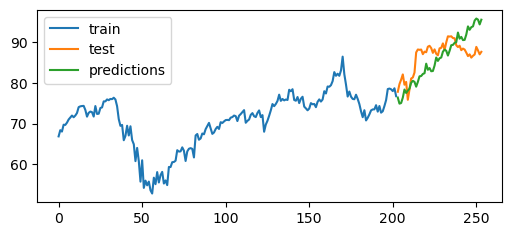

In [74]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)


# # Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train_goog['Close'].plot(ax=ax, label='train')
data_test_goog['Close'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [75]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test_goog['Close'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 22.14395749445258


In [76]:
# Random search hyperparameters and lags
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = DecisionTreeRegressor(random_state=123),
                 lags      = 10  # Placeholder, the value will be overwritten
             )

# Lags used as predictors
lags_grid = [3, 5]

# Regressor hyperparameters
param_distributions = {
    'max_depth': np.arange(start=1, stop=30, step=1, dtype=int),
    'min_samples_leaf': np.arange(start =1 , stop = 5, step = 1, dtype=int)
}

# Folds
cv = TimeSeriesFold(
         steps              = 12,
         initial_train_size =int(len(data_train_goog) * 0.60),
         refit              = False,
     )




results = random_search_forecaster(
              forecaster          = forecaster,
              y                   = final_goog['Close'],
              lags_grid           = lags_grid,
              param_distributions = param_distributions,
              cv                  = cv,
              n_iter              = 5,
              metric              = 'mean_squared_error',
              return_best         = True,
              random_state        = 123,
              n_jobs              = 'auto',
              verbose             = False,
              show_progress       = True
          )
results.head(4)

lags grid: 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'min_samples_leaf': 2, 'max_depth': 23}
  Backtesting metric: 59.08023509239043


,lags,lags_label,params,mean_squared_error,min_samples_leaf,max_depth
0,"[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'min_samples_leaf': 2, 'max_depth': 23}",59.080235,2,23
1,"[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'min_samples_leaf': 2, 'max_depth': 14}",59.080235,2,14
2,"[1, 2, 3]","[1, 2, 3]","{'min_samples_leaf': 2, 'max_depth': 23}",60.077514,2,23
3,"[1, 2, 3]","[1, 2, 3]","{'min_samples_leaf': 2, 'max_depth': 14}",60.077514,2,14


# Analysis 
For these models, the exogonous variables of tweets sentiment will not be utilised as their correlation with the stock close price was quite low 

## Backtesting with refit and fixed training size

- In this approach, the model is trained using a fixed window of past observations, and the testing is performed on a rolling basis, where the training window is moved forward in time. The size of the training window is kept constant, allowing for the model to be tested on different sections of the data. This technique is particularly useful when there is a limited amount of data available, or when the data is non-stationary, and the model's performance may vary over time. Is also known as time series cross-validation or walk-forward validation.

In [77]:
# Create and train forecaster with the best hyperparameters and lags found
# ==============================================================================
regressor = DecisionTreeRegressor(max_depth = None,max_features = "log2",min_samples_leaf= 2, min_samples_split= 2,random_state=123)
forecaster = ForecasterRecursive(
                 regressor = regressor,
                 lags      = 6,
                 differentiation=1
             )
forecaster.fit(y=data_train_goog['Close'],store_in_sample_residuals=True) 
#forecaster

cv = TimeSeriesFold(
         steps                 = 10,
         initial_train_size    = 150,
         refit                 = True,
         fixed_train_size      = False,
         gap                   = 0,
         allow_incomplete_fold = True,
         differentiation=1
     )

metric, predictions = backtesting_forecaster(
                          forecaster    = forecaster,
                          y             = final_goog['Close'],
                          cv            = cv,
                          metric        = 'mean_squared_error',
                          n_jobs        = 'auto',
                          verbose       = True,
                          show_progress = True
                      )

Information of folds
--------------------
Number of observations used for initial training: 149
    First 1 observation/s in training sets are used for differentiation
Number of observations used for backtesting: 104
    Number of folds: 11
    Number skipped folds: 0 
    Number of steps per fold: 10
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 4 observations.

Fold: 0
    Training:   1 -- 149  (n=149)
    Validation: 150 -- 159  (n=10)
Fold: 1
    Training:   1 -- 159  (n=159)
    Validation: 160 -- 169  (n=10)
Fold: 2
    Training:   1 -- 169  (n=169)
    Validation: 170 -- 179  (n=10)
Fold: 3
    Training:   1 -- 179  (n=179)
    Validation: 180 -- 189  (n=10)
Fold: 4
    Training:   1 -- 189  (n=189)
    Validation: 190 -- 199  (n=10)
Fold: 5
    Training:   1 -- 199  (n=199)
    Validation: 200 -- 209  (n=10)
Fold: 6
    Training:   1 -- 209  (n=209)
    Validation: 210 -- 219  (n=10)
Fold: 7
    Trai

100%|██████████| 11/11 [00:00<?, ?it/s]


In [78]:
# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(steps=60, interval=[5, 95], n_boot=100)
predictions.tail(7)

,pred,lower_bound,upper_bound
256,97.430808,63.455149,96.203317
257,97.618308,62.685138,95.863124
258,99.957974,64.923628,97.040694
259,98.464808,63.527921,97.658560
260,98.887308,64.971388,97.816391
261,98.103141,64.976226,99.133210
262,98.158311,61.995280,98.631854


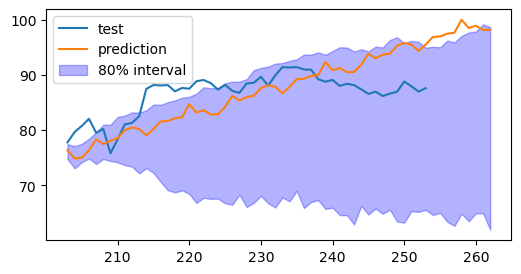

In [79]:
# Plot prediction interval
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data_test_goog['Close'].plot(ax=ax, label="test")
predictions['pred'].plot(ax=ax, label="prediction")
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'blue',
    alpha = 0.3,
    label = '80% interval'
)
ax.legend(loc="upper left");

In [80]:
forecaster.get_feature_importances()


,feature,importance
0,lag_1,0.307665
5,lag_6,0.227504
1,lag_2,0.126105
3,lag_4,0.122564
4,lag_5,0.112152
2,lag_3,0.104010


########################################################################################################################################  
########################################################################################################################################
########################################################################################################################################

# DEEP LEARNING

In [81]:
# Import libraries 

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import save_model, load_model
from kerastuner.tuners import RandomSearch, GridSearch
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

C:\Users\andre\AppData\Local\Temp\ipykernel_2472\2194782632.py:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch, GridSearch


# META LSTM 

In [82]:
import keras_tuner as kt

In [83]:
final_meta.head()

,Date,Open,High,Low,Close,Adj Close,Volume,company,Year,sentiment,knn_mean,knn_imputer,Close_pct_change,sentiment_imputed,sentiment_poly
0,2019-12-31,204.000000,205.559998,203.600006,205.250000,205.250000,8953500,META,2019,NaN,0.258300,0.066540,NaN,0.022067,NaN
1,2020-01-02,206.750000,209.789993,206.270004,209.779999,209.779999,12077100,META,2020,NaN,0.280875,0.227010,0.022067,0.022067,NaN
2,2020-01-03,207.210007,210.399994,206.949997,208.669998,208.669998,11188400,META,2020,NaN,0.280875,0.066540,-0.005291,-0.005291,NaN
3,2020-01-06,206.699997,212.779999,206.520004,212.600006,212.600006,17058900,META,2020,NaN,0.280875,-0.010555,0.018831,0.018831,NaN
4,2020-01-07,212.820007,214.580002,211.750000,213.059998,213.059998,14912400,META,2020,0.2583,0.258300,0.258300,0.002164,0.258300,0.2583


In [84]:
final_meta.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'company', 'Year', 'sentiment', 'knn_mean', 'knn_imputer',
       'Close_pct_change', 'sentiment_imputed', 'sentiment_poly'],
      dtype='object')

In [85]:
final_meta.describe()

,Open,High,Low,Close,Adj Close,Volume,Year,sentiment,knn_mean,knn_imputer,Close_pct_change,sentiment_imputed,sentiment_poly
count,254.000000,254.000000,254.000000,254.000000,254.000000,2.540000e+02,254.000000,111.000000,254.000000,254.000000,253.000000,254.000000,250.000000
mean,234.229213,237.812442,230.682993,234.435512,234.435512,2.239317e+07,2019.996063,0.091420,0.089606,0.107217,0.001549,0.039773,0.116644
std,38.753804,38.855385,38.491349,38.533341,38.533341,1.041488e+07,0.062746,0.328365,0.252896,0.259041,0.028862,0.222224,0.875735
min,139.750000,148.179993,137.100006,146.009995,146.009995,6.702000e+06,2019.000000,-0.900100,-0.900100,-0.900100,-0.141573,-0.900100,-4.657450
25%,209.452496,211.472496,206.989998,210.127499,210.127499,1.543755e+07,2020.000000,-0.030100,-0.052062,-0.009487,-0.013178,-0.013405,-0.155165
50%,236.949997,240.165001,232.209999,235.809998,235.809998,2.010380e+07,2020.000000,0.000000,0.042760,0.074277,0.002185,0.000000,0.046623
75%,268.845001,272.860001,265.174988,267.642509,267.642509,2.646915e+07,2020.000000,0.307275,0.269166,0.276500,0.015634,0.022012,0.464332
max,300.160004,304.670013,293.049988,303.910004,303.910004,7.634390e+07,2020.000000,0.877900,0.877900,0.877900,0.101994,0.877900,3.161411


In [86]:
features_meta = final_meta[['Open', 'High', 'Low', 'Close','sentiment_imputed']]
target_meta = final_meta['Close']

train_dates = pd.to_datetime(final_meta['Date']) 

In [87]:
#viewing the outliers to gain an understanding of which scaler to use
final_meta.query("Close > 268").count()

Date                 63
Open                 63
High                 63
Low                  63
Close                63
Adj Close            63
Volume               63
company              63
Year                 63
sentiment            28
knn_mean             63
knn_imputer          63
Close_pct_change     63
sentiment_imputed    63
sentiment_poly       63
dtype: int64

In [88]:
scaler = StandardScaler()
scaler = scaler.fit(features_meta)
df_for_training_scaled = scaler.transform(features_meta)


#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 


In [89]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1  # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

In [90]:
#240 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:features_meta.shape[1]])
    trainY.append(df_for_training_scaled[i:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (240, 14, 5).
trainY shape == (240, 1).


In [91]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(
        units=hp.Int('units', min_value=32, max_value=512, step=32),
        activation='relu',
        input_shape=(14, 5)
    ))
    model.add(keras.layers.Dense(1))  # output single scalar

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='mse',  # regression loss
                  metrics=['mae'])  # mean absolute error metric for regression

    return model


In [92]:
tuner = kt.Hyperband(model_builder,
                     objective='val_mae',  # monitor MAE for regression
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(trainX, trainY, epochs=50, validation_split=0.2, callbacks=[stop_early])


Reloading Tuner from my_dir\intro_to_kt\tuner0.json


In [93]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 128 and the optimal learning rate for the optimizer
is 0.01.



In [94]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(trainX, trainY, epochs=50, validation_split=0.2)

# Since this is regression, look for validation loss or MAE, not accuracy
val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch based on validation loss: %d' % best_epoch)

Epoch 1/50


c:\Users\andre\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.4829 - mae: 0.4614 - val_loss: 0.0252 - val_mae: 0.1154
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0547 - mae: 0.1671 - val_loss: 0.0864 - val_mae: 0.2663
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0385 - mae: 0.1536 - val_loss: 0.0395 - val_mae: 0.1768
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0285 - mae: 0.1256 - val_loss: 0.0223 - val_mae: 0.1126
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0213 - mae: 0.1096 - val_loss: 0.0123 - val_mae: 0.0783
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0211 - mae: 0.1052 - val_loss: 0.0126 - val_mae: 0.0852
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0170 - mae: 0.0938 - val_loss: 0.0120 - val_mae: 0.0771
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0155 - mae: 0.0914 - val_loss: 0.0134 - val_mae: 0.0801
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0154 - mae: 0.0927 - val_loss: 0

In [95]:
# # define the Autoencoder model
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dropout, Dense, LeakyReLU

# model = Sequential()
# model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))

# # Add LSTM without activation first, then add LeakyReLU as separate layer
# model.add(LSTM(32, return_sequences=False))
# model.add(LeakyReLU(alpha=0.1))  # LeakyReLU activation with alpha parameter

# model.add(Dropout(0.2))
# model.add(Dense(trainY.shape[1]))

# model.compile(optimizer='adam', loss='mse')
# model.summary()



Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0079 - mae: 0.0702 - val_loss: 0.0065 - val_mae: 0.0697
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0114 - mae: 0.0808 - val_loss: 0.0055 - val_mae: 0.0631
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0134 - mae: 0.0865 - val_loss: 0.0096 - val_mae: 0.0823
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0151 - mae: 0.0964 - val_loss: 0.0108 - val_mae: 0.0753
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0243 - mae: 0.1180 - val_loss: 0.0231 - val_mae: 0.1366


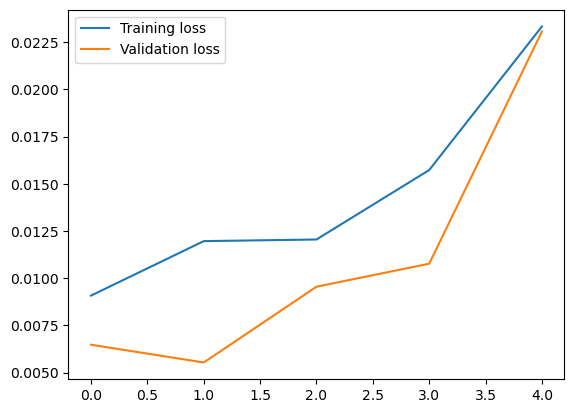

In [96]:
# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [97]:
#
n_future = 30
forecast_period_dates = pd.date_range(list(train_dates)[-1],periods = n_future,freq= '1d').tolist()

forecast = model.predict(trainX[-n_future:])

forecast.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


(30, 1)

In [98]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(forecast, features_meta.shape[1], axis=-1)
prediction_copies

array([[0.95871645, 0.95871645, 0.95871645, 0.95871645, 0.95871645],
       [0.91874987, 0.91874987, 0.91874987, 0.91874987, 0.91874987],
       [0.91120327, 0.91120327, 0.91120327, 0.91120327, 0.91120327],
       [0.84507483, 0.84507483, 0.84507483, 0.84507483, 0.84507483],
       [0.7918539 , 0.7918539 , 0.7918539 , 0.7918539 , 0.7918539 ],
       [0.99777275, 0.99777275, 0.99777275, 0.99777275, 0.99777275],
       [0.9443527 , 0.9443527 , 0.9443527 , 0.9443527 , 0.9443527 ],
       [1.0351839 , 1.0351839 , 1.0351839 , 1.0351839 , 1.0351839 ],
       [0.9839198 , 0.9839198 , 0.9839198 , 0.9839198 , 0.9839198 ],
       [1.2371665 , 1.2371665 , 1.2371665 , 1.2371665 , 1.2371665 ],
       [1.2142849 , 1.2142849 , 1.2142849 , 1.2142849 , 1.2142849 ],
       [1.1295303 , 1.1295303 , 1.1295303 , 1.1295303 , 1.1295303 ],
       [1.0374523 , 1.0374523 , 1.0374523 , 1.0374523 , 1.0374523 ],
       [1.2236706 , 1.2236706 , 1.2236706 , 1.2236706 , 1.2236706 ],
       [1.1388832 , 1.1388832 , 1.

In [99]:
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

C:\Users\andre\AppData\Local\Temp\ipykernel_2472\90748356.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


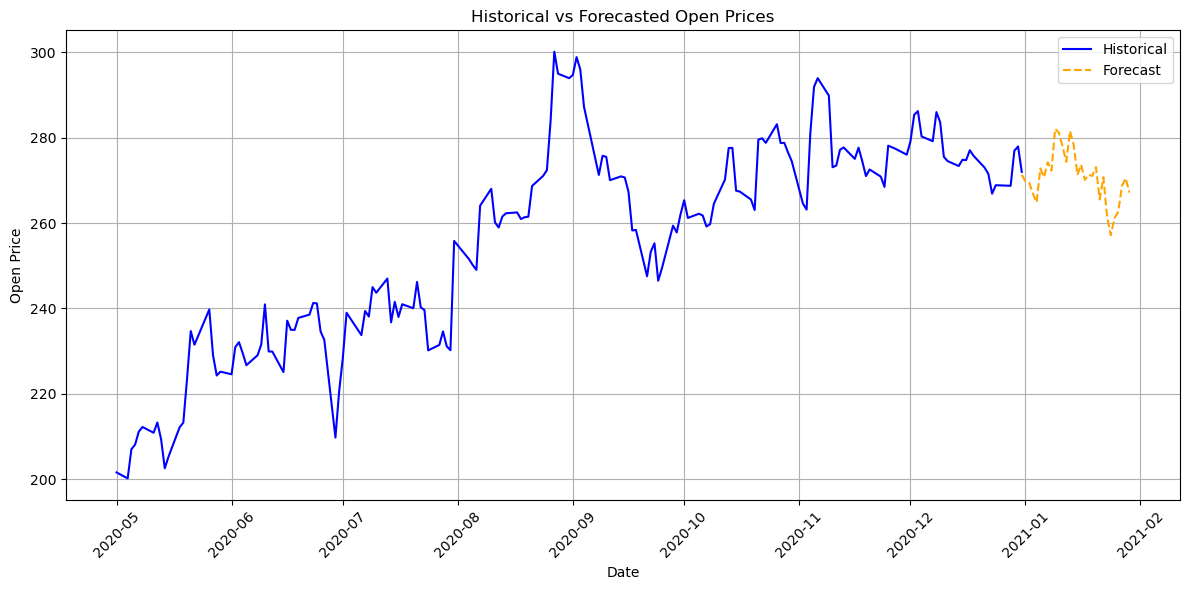

In [100]:
# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original =final_meta[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

plt.figure(figsize=(12, 6))
plt.plot(original['Date'], original['Open'], label='Historical', color='blue')
plt.plot(df_forecast['Date'], df_forecast['Open'], label='Forecast', color='orange', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Historical vs Forecasted Open Prices')
plt.xticks(rotation=45) 
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [101]:
df_forecast.head(7)

,Date,Open
0,2020-12-31,271.309906
1,2021-01-01,269.764099
2,2021-01-02,269.472229
3,2021-01-03,266.914551
4,2021-01-04,264.856110
5,2021-01-05,272.820496
6,2021-01-06,270.754364
